# Space Invaders DQN Agent

*Authors: Sahil Dhingra, Miguel Bravo*

Code for the advanced section of the coursework. The problem is the Atari game space invaders. Rules of the game can be found [here](https://atariage.com/manual_html_page.php?SoftwareLabelID=460). The agent used will be a Deep Q-Learning Network. Different variants of this agent will be covered: 
* Regular DQN
* Double DQN
* Double DQN with Prioritised Replay
* Double DQN with Prioritised Replay and Dueling architecture

## Training set-up

### Set training parameters

In [1]:
# settings that regularly change
RESUME_TRAINING = False
RESUME_TRAINING_DIR = 'INSERT_DIR_NAME_HERE'
N_EPISODES = 5000
N_ACTIONS = 5
BATCH_SIZE = 128
EPS_DECAY = 50 * N_EPISODES
TARGET_UPDATE = 500
L_RATE = 3e-4
INITIAL_MEMORY = 10000

# settings that stay the same
FRAMES_NUM = 4
GAMMA = 0.99 
EPS_START = 1.0
EPS_END = 0.01
MEMORY_SIZE = 200000

### Set working directory

In [2]:
#@title Run in google colab?
# this is to make use of gpu on colab.
# set to false if running locally on jupyter notebook
google_colab = False #@param {type:"boolean"}

In [3]:
# mount google drive if running from colab
if google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

In [4]:
# move to same directory where this notebook is (if using colab)
import os
if google_colab:
    os.chdir('/content/drive/My Drive/MSc Data Science/Deep Learning/Coursework/code')

### Set output directories

In [5]:
# set directory paths to save training outputs
agents_path = '../agents/'
stats_path = '../stats/'
plots_path = '../plots/'

# set output subdirectory
from datetime import datetime
date_today = datetime.strftime(datetime.now(), '%y%m%d%H%M')
output_dir = f'{date_today}_ee{EPS_END}_es{EPS_START}_ec{MEMORY_SIZE}_tu{TARGET_UPDATE}' + \
         f'_bs{BATCH_SIZE}_g{GAMMA}_lr{L_RATE}_na{N_ACTIONS}/'

In [6]:
# create subdirectories if they don't already exist
import os
if not os.path.exists(agents_path + output_dir):
    os.makedirs(agents_path + output_dir)
    
if not os.path.exists(stats_path + output_dir):
    os.makedirs(stats_path + output_dir)
    
if not os.path.exists(plots_path + output_dir):
    os.makedirs(plots_path + output_dir)

## Python set-up

### Install dependencies

In [7]:
# install gym atari envs
# run below line only once (then skip in future runs, as it's quite time-consuming)
!pip install gym[atari] --force-reinstall > /dev/null 2>&1

### Import libraries

In [8]:
# import libraries
import gym
from gym import logger as gymlogger
gymlogger.set_level(40) #error only

from itertools import count
import time
import json

import numpy as np
import random
import math
from collections import namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torchvision.transforms as T

from utils import *

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output

### Set device (GPU / CPU)

In [9]:
# set device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('running on device: {}'.format(device))

running on device: cuda


## Make Environment

In [10]:
# using stable baselines wrappers
env = gym.make('SpaceInvaders-v0')
env = make_SI_env(env) # baselines edited for Space Invaders - frame skipping set to 3 instead of 4

## DQN architecture - CNN

In [11]:
# DQN architecture 
class DeepQNetwork(nn.Module):

    def __init__(self, n_actions, dueling=False):
        super(DeepQNetwork, self).__init__()  
        
        self.dueling = dueling
        
        # conv layers
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        
        # compute width and dimension of final conv block feature maps (needed for fc block input size)
        def conv_out(size, kernel_size, stride, padding=0):
            return ((size - kernel_size + (2*padding))//stride) + 1
        
        # fully connected layers
        fm_dim_size = conv_out(conv_out(conv_out(84,8,4,padding=1),4,2),3,1)
        i_size = fm_dim_size * fm_dim_size * 128 #results in 7 * 7 size
        self.fc1 = nn.Linear(i_size, 512) 
        
        # define dueling architecture
        if self.dueling:
            self.adv = nn.Linear(512, n_actions)
            self.val = nn.Linear(512, 1)
        else:
            self.head = nn.Linear(512, n_actions)

    # forward pass
    def forward(self, x):
        x = x.float() / 255
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        #x = self.fc1(x.view(x.size(0), -1))
        x = self.fc1(x.reshape(x.size(0), -1))

        # apply dueling
        if self.dueling:
            adv = self.adv(x)
            val = self.val(x)
            return val + adv - adv.mean(dim = 1, keepdim = True)
        else:
            return self.head(x)

## Regular DQN

### Set up model

In [12]:
# double dqn
DOUBLE_DQN = False

# prioritised replay
PRIORITISED_REPLAY = False

# dueling dqn
DUELING = False

# instantiate dqn nets
policy_net_dqn = DeepQNetwork(n_actions=N_ACTIONS, dueling=DUELING).to(device)
target_net_dqn = DeepQNetwork(n_actions=N_ACTIONS, dueling=DUELING).to(device)
target_net_dqn.load_state_dict(policy_net_dqn.state_dict())
# target_net.eval()

# set optimiser
optimizer = optim.Adam(policy_net_dqn.parameters(), lr=L_RATE)

policy_net_dqn

DeepQNetwork(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (head): Linear(in_features=512, out_features=5, bias=True)
)

### Set output filenames

In [13]:
# get agent type to add into output
if DOUBLE_DQN:
    if PRIORITISED_REPLAY:
        if DUELING:
            agent = 'dpddqn'
        else:
            agent = 'pddqn'
    else:
        agent = 'ddqn'
else:
    agent = 'dqn'

agent_params = f"{agent}_params.pt"
stats_file = f"{agent}_stats.json"

print({'agent': agent, 'output folder': output_dir})

{'agent': 'dqn', 'output folder': '2005282139_ee0.01_es1.0_ec200000_tu500_bs128_g0.99_lr0.0003_na5/'}


### Restore model?

In [14]:
# decide whether to resume training from previous run
if RESUME_TRAINING:
    # restore agent from last checkpoint
    policy_net_ddqn.load_state_dict(torch.load(agents_path + RESUME_TRAINING_DIR + f'/{agent_params}',
                                          map_location=lambda storage, loc: storage))
    # restore last training stats
    with open(stats_path + RESUME_TRAINING_DIR + f'/{stats_file}', 'r') as fp:
        stats = json.load(fp)

    steps_done = stats['steps_done']
    episode_scores_dqn = stats['episode_scores']
    episode_eps_dqn = stats['episode_eps']
    episode_qs_dqn = stats['episode_qs']
    episodes_done = len(episode_scores)

### Reset replay memory?

In [15]:
if PRIORITISED_REPLAY:
    memory = PrioritisedReplayMemory(MEMORY_SIZE)
else:
    memory = ReplayMemory(MEMORY_SIZE)

### Training loop

In [16]:
# account for episodes done in previous run
if RESUME_TRAINING:
    N_EPISODES += episodes_done

# set timer
since = time.time()

# check memory size
if 'memory' in globals():
    if len(memory) > INITIAL_MEMORY:
        print('Memory initialised')
        print('-' * 10)
        if RESUME_TRAINING:
            print('Training episodes:', N_EPISODES - episodes_done)
        else:
            print('Training episodes:', N_EPISODES)
        print('-' * 10)

# resume training from previous run?
if RESUME_TRAINING:
    print(f'Resuming training at episode {episodes_done}')
    print('-' * 10)
    print('Training episodes:', N_EPISODES - episodes_done)
    print('-' * 10)
else:
    # initialise training stats if new run
    steps_done = 1
    episodes_done = 1
    episode_scores_dqn = []
    episode_eps_dqn = []
    episode_qs_dqn = []

# begin training
for episode in count():
    observation = env.reset()
    state = get_state(observation)
    # increase episodes done counter (once memory is initialised)
    if len(memory) > INITIAL_MEMORY:
        episodes_done += 1
    #create episode reward counter
    total_reward = 0.0
    for t in count():
        #select action
        action, epsilon_val = select_action(policy_net=policy_net_dqn, n_actions=N_ACTIONS, state=state, 
                                            eps_start=EPS_START, eps_end=EPS_END, eps_decay=EPS_DECAY, 
                                            steps_done=steps_done)
        
        #perform action
        if N_ACTIONS == 5:
            # add 1 to align net outputs (0-4) to env actions (1-5)
            observation, reward, done, info = env.step(action.item() + 1)
        elif N_ACTIONS == 6:
            observation, reward, done, info = env.step(action.item())
        
        if len(memory) > INITIAL_MEMORY:
            # increase steps done (once memory is initialised)
            steps_done += 1
        
        #increase reward
        total_reward += reward
        
        #get next state
        if not done:
            next_state = get_state(observation)
        else:
            next_state = None

        reward = torch.tensor([reward], device=device)
        
        #add observation to memory
        memory.push(state, action.to('cpu'), next_state, reward.to('cpu'))
        state = next_state
        
        # print memory initialisation progress
        if len(memory) < INITIAL_MEMORY:
            if t % 100 == 0:
                time_elapsed = time.time() - since
                clear_output(wait=True)
                print('Initialising memory \t Transitions: {}/{} \t Time: {:.0f}m {:.0f}s'.\
                    format(len(memory), INITIAL_MEMORY, time_elapsed//60, time_elapsed%60)) 
        elif len(memory) == INITIAL_MEMORY:
            time_elapsed = time.time() - since
            clear_output(wait=True)
            print('Initialising memory \t Transitions: {}/{} \t Time: {:.0f}m {:.0f}s'.\
                format(len(memory), INITIAL_MEMORY, time_elapsed//60, time_elapsed%60)) 
            print('-' * 10)
            print('Training episodes:', N_EPISODES - episodes_done + 1)
            print('-' * 10)
            break
        # optimise model (once memory is initialised)
        else:
            current_Q = optimize_model(policy_net=policy_net_dqn, target_net=target_net_dqn, optimizer=optimizer, 
                                       gamma=GAMMA, memory=memory, batch_size=BATCH_SIZE, 
                                       double_dqn=DOUBLE_DQN, prioritised_replay=PRIORITISED_REPLAY)
            
            # calculate average q value
            avg_Q = current_Q.detach().cpu().numpy().mean().astype(np.float64)

            # update target net
            if steps_done % TARGET_UPDATE == 0:
                target_net_dqn.load_state_dict(policy_net_dqn.state_dict())
        
        # end episode if done
        if done:
            break
            
    # print training stats
    if len(memory) > INITIAL_MEMORY:
        time_elapsed = time.time() - since
        if episodes_done % 10 == 0:
            print('T steps: {} \t Mem: {} \t Epi: {} \t Eps: {:.4f} \t Q: {:.4f} \t Score: {} \t Time: {:.0f}m {:.0f}s'.\
                format(steps_done, len(memory), episodes_done, epsilon_val, avg_Q, total_reward, time_elapsed//60, time_elapsed%60))          
                
        # track total score for each episode
        episode_scores_dqn.append(total_reward)
        # track epsilon threshold for each episode
        episode_eps_dqn.append(epsilon_val)
        # track average q for each episode
        episode_qs_dqn.append(avg_Q)
                
        # save model down
        torch.save(policy_net_dqn.state_dict(), agents_path + output_dir + agent_params)
        # save training stats down
        stats = {'steps_done': steps_done, 'episode_scores': episode_scores_dqn, 
                'episode_eps': episode_eps_dqn, 'episode_qs': episode_qs_dqn}
        with open(stats_path + output_dir + stats_file, 'w') as fp:
            json.dump(stats, fp)

    # end training once n_episodes reached
    if episodes_done == N_EPISODES:
        break

print('-' * 10)
print('Training complete')
print('-' * 10)


Initialising memory 	 Transitions: 10000/10000 	 Time: 1m 9s
----------
Training episodes: 5000
----------
T steps: 458 	 Mem: 10458 	 Epi: 10 	 Eps: 0.9982 	 Q: 0.5098 	 Score: 5.0 	 Time: 1m 35s
T steps: 1229 	 Mem: 11229 	 Epi: 20 	 Eps: 0.9951 	 Q: 2.4479 	 Score: 45.0 	 Time: 2m 16s
T steps: 1893 	 Mem: 11893 	 Epi: 30 	 Eps: 0.9925 	 Q: 2.6718 	 Score: 320.0 	 Time: 2m 53s
T steps: 2808 	 Mem: 12808 	 Epi: 40 	 Eps: 0.9889 	 Q: 6.8248 	 Score: 75.0 	 Time: 3m 40s
T steps: 3836 	 Mem: 13836 	 Epi: 50 	 Eps: 0.9849 	 Q: 8.6009 	 Score: 365.0 	 Time: 4m 32s
T steps: 4766 	 Mem: 14766 	 Epi: 60 	 Eps: 0.9813 	 Q: 11.7322 	 Score: 50.0 	 Time: 5m 20s
T steps: 5399 	 Mem: 15399 	 Epi: 70 	 Eps: 0.9789 	 Q: 18.2397 	 Score: 5.0 	 Time: 5m 52s
T steps: 5920 	 Mem: 15920 	 Epi: 80 	 Eps: 0.9768 	 Q: 17.9921 	 Score: 20.0 	 Time: 6m 19s
T steps: 6394 	 Mem: 16394 	 Epi: 90 	 Eps: 0.9750 	 Q: 20.1957 	 Score: 0.0 	 Time: 6m 44s
T steps: 7223 	 Mem: 17223 	 Epi: 100 	 Eps: 0.9718 	 Q: 24.893

### Plot training stats

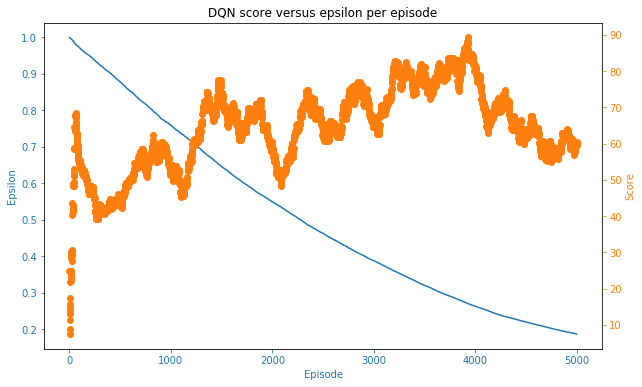

In [84]:
# plot score scatter chart overlaid with epsilon to see relationships

fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.plot(range(len(episode_eps_dqn)), episode_eps_dqn, color="C0")
ax.set_xlabel("Episode", color="C0")
ax.set_ylabel("Epsilon", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")

N = len(episode_scores_dqn)
running_avg = np.empty(N)
for t in range(N):
    running_avg[t] = np.mean(episode_scores_dqn[max(0, t-200):(t+1)])

ax2.scatter(range(len(running_avg)), running_avg, color="C1")
ax2.axes.get_xaxis().set_visible(False)
ax2.yaxis.tick_right()
ax2.set_ylabel('Score', color="C1")
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='y', colors="C1")

plt.title(f'DQN score versus epsilon per episode')
plt.savefig(plots_path + output_dir + f'{agent}_score_vs_eps_plot.png')
plt.show()

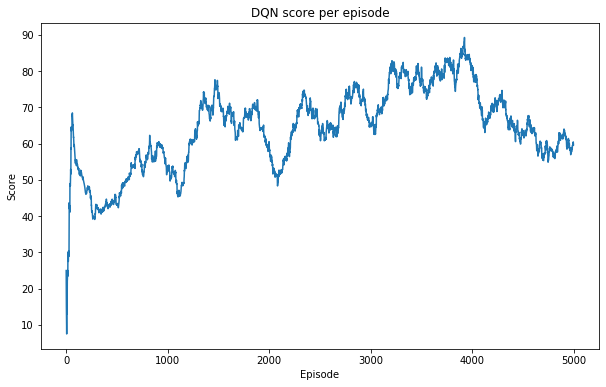

In [82]:
# plot score over episodes

plt.figure(figsize=(10,6))

# get moving average
N = len(episode_scores_dqn)
running_avg = np.empty(N)
for t in range(N):
    running_avg[t] = np.mean(episode_scores_dqn[max(0, t-200):(t+1)])

# do plot
plt.plot(range(len(running_avg)), running_avg)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title(f'DQN score per episode')
plt.savefig(plots_path + output_dir + f'{agent}_score_plot.png')
plt.show()

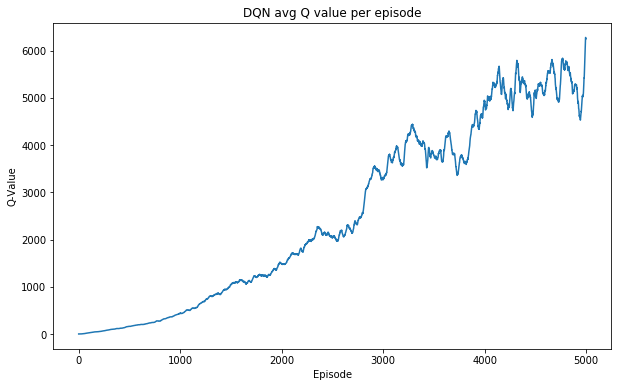

In [81]:
# plot q values over episodes

plt.figure(figsize=(10,6))

# get moving average
N = len(episode_scores_dqn)
running_avg = np.empty(N)
for t in range(N):
    running_avg[t] = np.mean(episode_qs_dqn[max(0, t-20):(t+1)])

# do plot
plt.plot(range(len(running_avg)), running_avg)
plt.xlabel('Episode')
plt.ylabel('Q-Value')
plt.title(f'DQN avg Q value per episode')
plt.savefig(plots_path + output_dir + f'{agent}_qvalue_plot.png')
plt.show()

## Double DQN

### Set up model

In [20]:
# double dqn
DOUBLE_DQN = True

# prioritised replay
PRIORITISED_REPLAY = False

# dueling dqn
DUELING = False

# instantiate dqn nets
policy_net_ddqn = DeepQNetwork(n_actions=N_ACTIONS, dueling=DUELING).to(device)
target_net_ddqn = DeepQNetwork(n_actions=N_ACTIONS, dueling=DUELING).to(device)
target_net_ddqn.load_state_dict(policy_net_ddqn.state_dict())
# target_net.eval()

# set optimiser
optimizer = optim.Adam(policy_net_ddqn.parameters(), lr=L_RATE)

policy_net_ddqn

DeepQNetwork(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (head): Linear(in_features=512, out_features=5, bias=True)
)

### Set output filenames

In [21]:
# get agent type to add into output
if DOUBLE_DQN:
    if PRIORITISED_REPLAY:
        if DUELING:
            agent = 'dpddqn'
        else:
            agent = 'pddqn'
    else:
        agent = 'ddqn'
else:
    agent = 'dqn'

agent_params = f"{agent}_params.pt"
stats_file = f"{agent}_stats.json"

print({'agent': agent, 'output folder': output_dir})

{'agent': 'ddqn', 'output folder': '2005282139_ee0.01_es1.0_ec200000_tu500_bs128_g0.99_lr0.0003_na5/'}


### Restore model?

In [22]:
# decide whether to resume training from previous run
if RESUME_TRAINING:
    # restore agent from last checkpoint
    policy_net_ddqn.load_state_dict(torch.load(agents_path + RESUME_TRAINING_DIR + f'/{agent_params}',
                                          map_location=lambda storage, loc: storage))
    # restore last training stats
    with open(stats_path + RESUME_TRAINING_DIR + f'/{stats_file}', 'r') as fp:
        stats = json.load(fp)

    steps_done = stats['steps_done']
    episode_scores_dqn = stats['episode_scores']
    episode_eps_dqn = stats['episode_eps']
    episode_qs_dqn = stats['episode_qs']
    episodes_done = len(episode_scores)

### Reset replay memory?

In [23]:
# initialize replay memory
if PRIORITISED_REPLAY:
    memory = PrioritisedReplayMemory(MEMORY_SIZE)
else:
    memory = ReplayMemory(MEMORY_SIZE)

### Training loop

In [24]:
# account for episodes done in previous run
if RESUME_TRAINING:
    N_EPISODES += episodes_done

# set timer
since = time.time()

# check memory size
if 'memory' in globals():
    if len(memory) > INITIAL_MEMORY:
        print('Memory initialised')
        print('-' * 10)
        if RESUME_TRAINING:
            print('Training episodes:', N_EPISODES - episodes_done)
        else:
            print('Training episodes:', N_EPISODES)
        print('-' * 10)

# resume training from previous run?
if RESUME_TRAINING:
    print(f'Resuming training at episode {episodes_done}')
    print('-' * 10)
    print('Training episodes:', N_EPISODES - episodes_done)
    print('-' * 10)
else:
    # initialise training stats if new run
    steps_done = 1
    episodes_done = 1
    episode_scores_ddqn = []
    episode_eps_ddqn = []
    episode_qs_ddqn = []

# begin training
for episode in count():
    observation = env.reset()
    state = get_state(observation)
    # increase episodes done counter (once memory is initialised)
    if len(memory) > INITIAL_MEMORY:
        episodes_done += 1
    #create episode reward counter
    total_reward = 0.0
    for t in count():
        #select action
        action, epsilon_val = select_action(policy_net=policy_net_ddqn, n_actions=N_ACTIONS, state=state, 
                                            eps_start=EPS_START, eps_end=EPS_END, eps_decay=EPS_DECAY, 
                                            steps_done=steps_done)
        
        #perform action
        if N_ACTIONS == 5:
            # add 1 to align net outputs (0-4) to env actions (1-5)
            observation, reward, done, info = env.step(action.item() + 1)
        elif N_ACTIONS == 6:
            observation, reward, done, info = env.step(action.item())
        
        if len(memory) > INITIAL_MEMORY:
            # increase steps done (once memory is initialised)
            steps_done += 1
        
        #increase reward
        total_reward += reward
        
        #get next state
        if not done:
            next_state = get_state(observation)
        else:
            next_state = None

        reward = torch.tensor([reward], device=device)
        
        #add observation to memory
        memory.push(state, action.to('cpu'), next_state, reward.to('cpu'))
        state = next_state
        
        # print memory initialisation progress
        if len(memory) < INITIAL_MEMORY:
            if t % 100 == 0:
                time_elapsed = time.time() - since
                clear_output(wait=True)
                print('Initialising memory \t Transitions: {}/{} \t Time: {:.0f}m {:.0f}s'.\
                    format(len(memory), INITIAL_MEMORY, time_elapsed//60, time_elapsed%60)) 
        elif len(memory) == INITIAL_MEMORY:
            time_elapsed = time.time() - since
            clear_output(wait=True)
            print('Initialising memory \t Transitions: {}/{} \t Time: {:.0f}m {:.0f}s'.\
                format(len(memory), INITIAL_MEMORY, time_elapsed//60, time_elapsed%60)) 
            print('-' * 10)
            print('Training episodes:', N_EPISODES - episodes_done + 1)
            print('-' * 10)
            break
        # optimise model (once memory is initialised)
        else:
            current_Q = optimize_model(policy_net=policy_net_ddqn, target_net=target_net_ddqn, optimizer=optimizer, 
                                       gamma=GAMMA, memory=memory, batch_size=BATCH_SIZE, 
                                       double_dqn=DOUBLE_DQN, prioritised_replay=PRIORITISED_REPLAY)
            
            # calculate average q value
            avg_Q = current_Q.detach().cpu().numpy().mean().astype(np.float64)

            # update target net
            if steps_done % TARGET_UPDATE == 0:
                target_net_ddqn.load_state_dict(policy_net_ddqn.state_dict())
        
        # end episode if done
        if done:
            break
            
    # print training stats
    if len(memory) > INITIAL_MEMORY:
        time_elapsed = time.time() - since
        if episodes_done % 10 == 0:
            print('T steps: {} \t Mem: {} \t Epi: {} \t Eps: {:.4f} \t Q: {:.4f} \t Score: {} \t Time: {:.0f}m {:.0f}s'.\
                format(steps_done, len(memory), episodes_done, epsilon_val, avg_Q, total_reward, time_elapsed//60, time_elapsed%60))          
                
        # track total score for each episode
        episode_scores_ddqn.append(total_reward)
        # track epsilon threshold for each episode
        episode_eps_ddqn.append(epsilon_val)
        # track average q for each episode
        episode_qs_ddqn.append(avg_Q)
                
        # save model down
        torch.save(policy_net_ddqn.state_dict(), agents_path + output_dir + agent_params)
        # save training stats down
        stats = {'steps_done': steps_done, 'episode_scores': episode_scores_ddqn, 
                'episode_eps': episode_eps_ddqn, 'episode_qs': episode_qs_ddqn}
        with open(stats_path + output_dir + stats_file, 'w') as fp:
            json.dump(stats, fp)


    # end training once n_episodes reached
    if episodes_done == N_EPISODES:
        break

print('-' * 10)
print('Training complete')
print('-' * 10)


Initialising memory 	 Transitions: 10000/10000 	 Time: 1m 18s
----------
Training episodes: 5000
----------
T steps: 489 	 Mem: 10489 	 Epi: 10 	 Eps: 0.9981 	 Q: 0.9576 	 Score: 0.0 	 Time: 1m 46s
T steps: 1048 	 Mem: 11048 	 Epi: 20 	 Eps: 0.9959 	 Q: 1.7625 	 Score: 30.0 	 Time: 2m 17s
T steps: 1594 	 Mem: 11594 	 Epi: 30 	 Eps: 0.9937 	 Q: 3.5170 	 Score: 0.0 	 Time: 2m 49s
T steps: 2394 	 Mem: 12394 	 Epi: 40 	 Eps: 0.9906 	 Q: 5.3182 	 Score: 75.0 	 Time: 3m 34s
T steps: 2935 	 Mem: 12935 	 Epi: 50 	 Eps: 0.9884 	 Q: 6.3482 	 Score: 15.0 	 Time: 4m 4s
T steps: 3425 	 Mem: 13425 	 Epi: 60 	 Eps: 0.9865 	 Q: 8.2891 	 Score: 55.0 	 Time: 4m 33s
T steps: 4033 	 Mem: 14033 	 Epi: 70 	 Eps: 0.9842 	 Q: 11.2171 	 Score: 110.0 	 Time: 5m 7s
T steps: 4513 	 Mem: 14513 	 Epi: 80 	 Eps: 0.9823 	 Q: 14.5081 	 Score: 0.0 	 Time: 5m 34s
T steps: 5229 	 Mem: 15229 	 Epi: 90 	 Eps: 0.9795 	 Q: 13.6168 	 Score: 5.0 	 Time: 6m 15s
T steps: 5809 	 Mem: 15809 	 Epi: 100 	 Eps: 0.9773 	 Q: 14.8414 	 

### Plot training stats

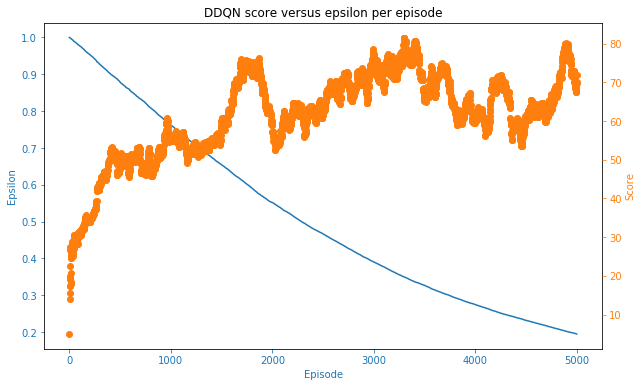

In [71]:
# plot score scatter chart overlaid with epsilon to see relationships

fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.plot(range(len(episode_eps_ddqn)), episode_eps_ddqn, color="C0")
ax.set_xlabel("Episode", color="C0")
ax.set_ylabel("Epsilon", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")

N = len(episode_scores_ddqn)
running_avg = np.empty(N)
for t in range(N):
    running_avg[t] = np.mean(episode_scores_ddqn[max(0, t-200):(t+1)])

ax2.scatter(range(len(running_avg)), running_avg, color="C1")
ax2.axes.get_xaxis().set_visible(False)
ax2.yaxis.tick_right()
ax2.set_ylabel('Score', color="C1")
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='y', colors="C1")

plt.title(f'DDQN score versus epsilon per episode')
plt.savefig(plots_path + output_dir + f'{agent}_score_vs_eps_plot.png')
plt.show()

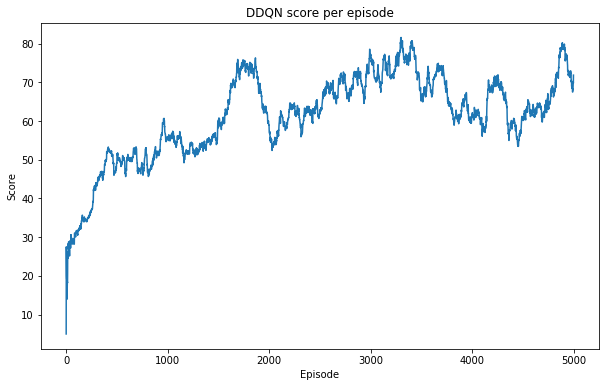

In [83]:
# plot score over episodes

plt.figure(figsize=(10,6))

# get moving average
N = len(episode_scores_ddqn)
running_avg = np.empty(N)
for t in range(N):
    running_avg[t] = np.mean(episode_scores_ddqn[max(0, t-200):(t+1)])

# do plot
plt.plot(range(len(running_avg)), running_avg)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title(f'DDQN score per episode')
plt.savefig(plots_path + output_dir + f'{agent}_score_plot.png')
plt.show()

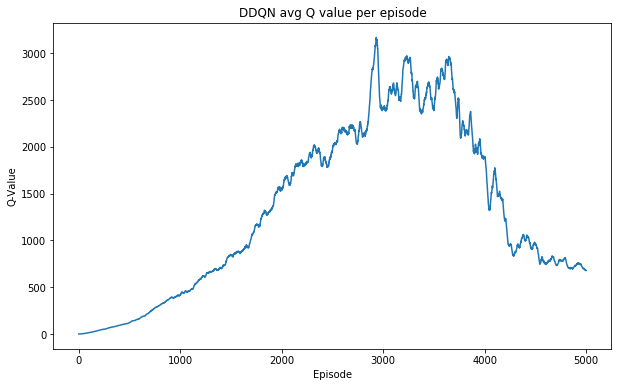

In [80]:
# plot q values over episodes

plt.figure(figsize=(10,6))

# get moving average
N = len(episode_scores_ddqn)
running_avg = np.empty(N)
for t in range(N):
    running_avg[t] = np.mean(episode_qs_ddqn[max(0, t-20):(t+1)])

# do plot
plt.plot(range(len(running_avg)), running_avg)
plt.xlabel('Episode')
plt.ylabel('Q-Value')
plt.title(f'DDQN avg Q value per episode')
plt.savefig(plots_path + output_dir + f'{agent}_qvalue_plot.png')
plt.show()

## Prioritised Double DQN

### Set up model

In [28]:
# double dqn
DOUBLE_DQN = True

# prioritised replay
PRIORITISED_REPLAY = True

# dueling dqn
DUELING = False

# instantiate dqn nets
policy_net_pddqn = DeepQNetwork(n_actions=N_ACTIONS, dueling=DUELING).to(device)
target_net_pddqn = DeepQNetwork(n_actions=N_ACTIONS, dueling=DUELING).to(device)
target_net_pddqn.load_state_dict(policy_net_pddqn.state_dict())
# target_net.eval()

# set optimiser
optimizer = optim.Adam(policy_net_pddqn.parameters(), lr=L_RATE)

policy_net_pddqn

DeepQNetwork(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (head): Linear(in_features=512, out_features=5, bias=True)
)

### Set output filenames

In [29]:
# get agent type to add into output
if DOUBLE_DQN:
    if PRIORITISED_REPLAY:
        if DUELING:
            agent = 'dpddqn'
        else:
            agent = 'pddqn'
    else:
        agent = 'ddqn'
else:
    agent = 'dqn'

agent_params = f"{agent}_params.pt"
stats_file = f"{agent}_stats.json"

print({'agent': agent, 'output folder': output_dir})

{'agent': 'pddqn', 'output folder': '2005282139_ee0.01_es1.0_ec200000_tu500_bs128_g0.99_lr0.0003_na5/'}


### Restore model?

In [30]:
# decide whether to resume training from previous run
if RESUME_TRAINING:
    # restore agent from last checkpoint
    policy_net_ddqn.load_state_dict(torch.load(agents_path + RESUME_TRAINING_DIR + f'/{agent_params}',
                                          map_location=lambda storage, loc: storage))
    # restore last training stats
    with open(stats_path + RESUME_TRAINING_DIR + f'/{stats_file}', 'r') as fp:
        stats = json.load(fp)

    steps_done = stats['steps_done']
    episode_scores_dqn = stats['episode_scores']
    episode_eps_dqn = stats['episode_eps']
    episode_qs_dqn = stats['episode_qs']
    episodes_done = len(episode_scores)

### Reset replay memory?

In [31]:
# initialize replay memory
if PRIORITISED_REPLAY:
    memory = PrioritisedReplayMemory(MEMORY_SIZE)
else:
    memory = ReplayMemory(MEMORY_SIZE)

### Training loop

In [32]:
# account for episodes done in previous run
if RESUME_TRAINING:
    N_EPISODES += episodes_done

# set timer
since = time.time()

# check memory size
if 'memory' in globals():
    if len(memory) > INITIAL_MEMORY:
        print('Memory initialised')
        print('-' * 10)
        if RESUME_TRAINING:
            print('Training episodes:', N_EPISODES - episodes_done)
        else:
            print('Training episodes:', N_EPISODES)
        print('-' * 10)

# resume training from previous run?
if RESUME_TRAINING:
    print(f'Resuming training at episode {episodes_done}')
    print('-' * 10)
    print('Training episodes:', N_EPISODES - episodes_done)
    print('-' * 10)
else:
    # initialise training stats if new run
    steps_done = 1
    episodes_done = 1
    episode_scores_pddqn = []
    episode_eps_pddqn = []
    episode_qs_pddqn = []

# begin training
for episode in count():
    observation = env.reset()
    state = get_state(observation)
    # increase episodes done counter (once memory is initialised)
    if len(memory) > INITIAL_MEMORY:
        episodes_done += 1
    #create episode reward counter
    total_reward = 0.0
    for t in count():
        #select action
        action, epsilon_val = select_action(policy_net=policy_net_pddqn, n_actions=N_ACTIONS, state=state, 
                                            eps_start=EPS_START, eps_end=EPS_END, eps_decay=EPS_DECAY, 
                                            steps_done=steps_done)
        
        #perform action
        if N_ACTIONS == 5:
            # add 1 to align net outputs (0-4) to env actions (1-5)
            observation, reward, done, info = env.step(action.item() + 1)
        elif N_ACTIONS == 6:
            observation, reward, done, info = env.step(action.item())
        
        if len(memory) > INITIAL_MEMORY:
            # increase steps done (once memory is initialised)
            steps_done += 1
        
        #increase reward
        total_reward += reward
        
        #get next state
        if not done:
            next_state = get_state(observation)
        else:
            next_state = None

        reward = torch.tensor([reward], device=device)
        
        #add observation to memory
        memory.push(state, action.to('cpu'), next_state, reward.to('cpu'))
        state = next_state
        
        # print memory initialisation progress
        if len(memory) < INITIAL_MEMORY:
            if t % 100 == 0:
                time_elapsed = time.time() - since
                clear_output(wait=True)
                print('Initialising memory \t Transitions: {}/{} \t Time: {:.0f}m {:.0f}s'.\
                    format(len(memory), INITIAL_MEMORY, time_elapsed//60, time_elapsed%60)) 
        elif len(memory) == INITIAL_MEMORY:
            time_elapsed = time.time() - since
            clear_output(wait=True)
            print('Initialising memory \t Transitions: {}/{} \t Time: {:.0f}m {:.0f}s'.\
                format(len(memory), INITIAL_MEMORY, time_elapsed//60, time_elapsed%60)) 
            print('-' * 10)
            print('Training episodes:', N_EPISODES - episodes_done + 1)
            print('-' * 10)
            break
        # optimise model (once memory is initialised)
        else:
            current_Q = optimize_model(policy_net=policy_net_pddqn, target_net=target_net_pddqn, optimizer=optimizer, 
                                       gamma=GAMMA, memory=memory, batch_size=BATCH_SIZE, 
                                       double_dqn=DOUBLE_DQN, prioritised_replay=PRIORITISED_REPLAY)
            
            # calculate average q value
            avg_Q = current_Q.detach().cpu().numpy().mean().astype(np.float64)

            # update target net
            if steps_done % TARGET_UPDATE == 0:
                target_net_pddqn.load_state_dict(policy_net_pddqn.state_dict())
        
        # end episode if done
        if done:
            break
            
    # print training stats
    if len(memory) > INITIAL_MEMORY:
        time_elapsed = time.time() - since
        if episodes_done % 10 == 0:
            print('T steps: {} \t Mem: {} \t Epi: {} \t Eps: {:.4f} \t Q: {:.4f} \t Score: {} \t Time: {:.0f}m {:.0f}s'.\
                format(steps_done, len(memory), episodes_done, epsilon_val, avg_Q, total_reward, time_elapsed//60, time_elapsed%60))          
                
        # track total score for each episode
        episode_scores_pddqn.append(total_reward)
        # track epsilon threshold for each episode
        episode_eps_pddqn.append(epsilon_val)
        # track average q for each episode
        episode_qs_pddqn.append(avg_Q)
                
        # save model down
        torch.save(policy_net_pddqn.state_dict(), agents_path + output_dir + agent_params)
        # save training stats down
        stats = {'steps_done': steps_done, 'episode_scores': episode_scores_pddqn, 
                'episode_eps': episode_eps_pddqn, 'episode_qs': episode_qs_pddqn}
        with open(stats_path + output_dir + stats_file, 'w') as fp:
            json.dump(stats, fp)


    # end training once n_episodes reached
    if episodes_done == N_EPISODES:
        break

print('-' * 10)
print('Training complete')
print('-' * 10)


Initialising memory 	 Transitions: 10000/10000 	 Time: 1m 32s
----------
Training episodes: 5000
----------
T steps: 862 	 Mem: 10862 	 Epi: 10 	 Eps: 0.9966 	 Q: 3.8088 	 Score: 190.0 	 Time: 2m 20s
T steps: 1697 	 Mem: 11697 	 Epi: 20 	 Eps: 0.9933 	 Q: 18.7360 	 Score: 40.0 	 Time: 3m 6s
T steps: 2267 	 Mem: 12267 	 Epi: 30 	 Eps: 0.9911 	 Q: 14.1096 	 Score: 125.0 	 Time: 3m 38s
T steps: 2830 	 Mem: 12830 	 Epi: 40 	 Eps: 0.9889 	 Q: 26.6615 	 Score: 60.0 	 Time: 4m 10s
T steps: 3535 	 Mem: 13535 	 Epi: 50 	 Eps: 0.9861 	 Q: 31.7790 	 Score: 30.0 	 Time: 4m 49s
T steps: 3971 	 Mem: 13971 	 Epi: 60 	 Eps: 0.9844 	 Q: 25.9632 	 Score: 30.0 	 Time: 5m 14s
T steps: 4739 	 Mem: 14739 	 Epi: 70 	 Eps: 0.9814 	 Q: 32.4756 	 Score: 30.0 	 Time: 5m 57s
T steps: 5413 	 Mem: 15413 	 Epi: 80 	 Eps: 0.9788 	 Q: 36.2292 	 Score: 55.0 	 Time: 6m 35s
T steps: 6075 	 Mem: 16075 	 Epi: 90 	 Eps: 0.9762 	 Q: 37.8986 	 Score: 15.0 	 Time: 7m 12s
T steps: 7073 	 Mem: 17073 	 Epi: 100 	 Eps: 0.9724 	 Q:

### Plot training stats

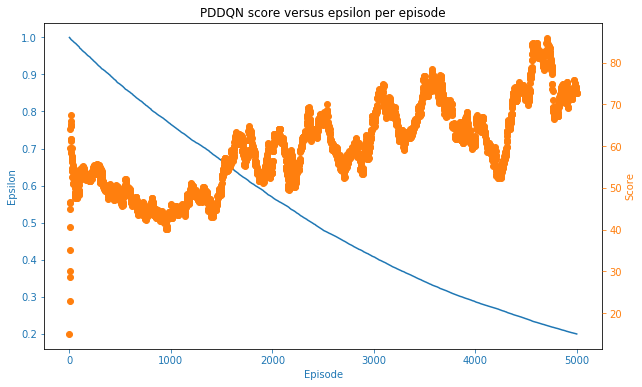

In [72]:
# plot score scatter chart overlaid with epsilon to see relationships

fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.plot(range(len(episode_eps_pddqn)), episode_eps_pddqn, color="C0")
ax.set_xlabel("Episode", color="C0")
ax.set_ylabel("Epsilon", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")

N = len(episode_scores_pddqn)
running_avg = np.empty(N)
for t in range(N):
    running_avg[t] = np.mean(episode_scores_pddqn[max(0, t-200):(t+1)])

ax2.scatter(range(len(running_avg)), running_avg, color="C1")
ax2.axes.get_xaxis().set_visible(False)
ax2.yaxis.tick_right()
ax2.set_ylabel('Score', color="C1")
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='y', colors="C1")

plt.title(f'PDDQN score versus epsilon per episode')
plt.savefig(plots_path + output_dir + f'{agent}_score_vs_eps_plot.png')
plt.show()

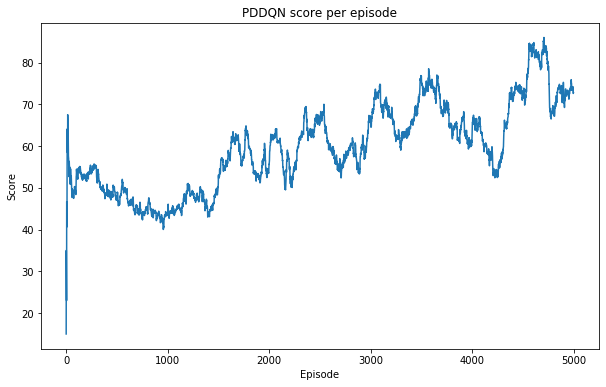

In [75]:
# plot score over episodes

plt.figure(figsize=(10,6))

# get moving average
N = len(episode_scores_pddqn)
running_avg = np.empty(N)
for t in range(N):
    running_avg[t] = np.mean(episode_scores_pddqn[max(0, t-200):(t+1)])

# do plot
plt.plot(range(len(running_avg)), running_avg)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title(f'PDDQN score per episode')
plt.savefig(plots_path + output_dir + f'{agent}_score_plot.png')
plt.show()

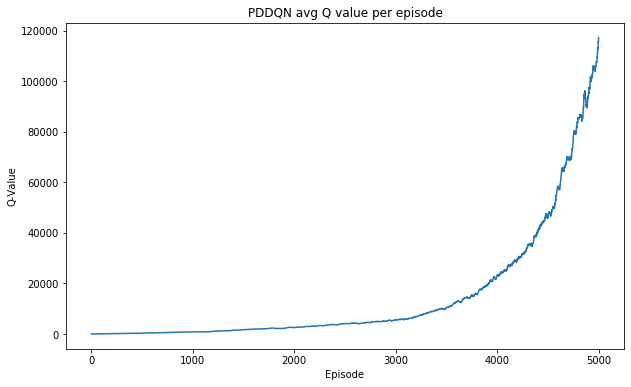

In [79]:
# plot q values over episodes

plt.figure(figsize=(10,6))

# get moving average
N = len(episode_scores_pddqn)
running_avg = np.empty(N)
for t in range(N):
    running_avg[t] = np.mean(episode_qs_pddqn[max(0, t-20):(t+1)])

# do plot
plt.plot(range(len(running_avg)), running_avg)
plt.xlabel('Episode')
plt.ylabel('Q-Value')
plt.title(f'PDDQN avg Q value per episode')
plt.savefig(plots_path + output_dir + f'{agent}_qvalue_plot.png')
plt.show()

## Dueling Prioritised Double DQN

### Set up model

In [36]:
# double dqn
DOUBLE_DQN = True

# prioritised replay
PRIORITISED_REPLAY = True

# dueling dqn
DUELING = True

# instantiate dqn nets
policy_net_dpddqn = DeepQNetwork(n_actions=N_ACTIONS, dueling=DUELING).to(device)
target_net_dpddqn = DeepQNetwork(n_actions=N_ACTIONS, dueling=DUELING).to(device)
target_net_dpddqn.load_state_dict(policy_net_dpddqn.state_dict())
# target_net.eval()

# set optimiser
optimizer = optim.Adam(policy_net_dpddqn.parameters(), lr=L_RATE)

policy_net_dpddqn

DeepQNetwork(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (adv): Linear(in_features=512, out_features=5, bias=True)
  (val): Linear(in_features=512, out_features=1, bias=True)
)

### Set output filenames

In [37]:
# get agent type to add into output
if DOUBLE_DQN:
    if PRIORITISED_REPLAY:
        if DUELING:
            agent = 'dpddqn'
        else:
            agent = 'pddqn'
    else:
        agent = 'ddqn'
else:
    agent = 'dqn'

agent_params = f"{agent}_params.pt"
stats_file = f"{agent}_stats.json"

print({'agent': agent, 'output folder': output_dir})

{'agent': 'dpddqn', 'output folder': '2005282139_ee0.01_es1.0_ec200000_tu500_bs128_g0.99_lr0.0003_na5/'}


### Restore model?

In [38]:
# decide whether to resume training from previous run
if RESUME_TRAINING:
    # restore agent from last checkpoint
    policy_net_ddqn.load_state_dict(torch.load(agents_path + RESUME_TRAINING_DIR + f'/{agent_params}',
                                          map_location=lambda storage, loc: storage))
    # restore last training stats
    with open(stats_path + RESUME_TRAINING_DIR + f'/{stats_file}', 'r') as fp:
        stats = json.load(fp)

    steps_done = stats['steps_done']
    episode_scores_ddqn = stats['episode_scores']
    episode_eps_dqn = stats['episode_eps']
    episode_qs_dqn = stats['episode_qs']
    episodes_done = len(episode_scores)

### Reset replay memory?

In [42]:
# initialize replay memory
if PRIORITISED_REPLAY:
    memory = PrioritisedReplayMemory(MEMORY_SIZE)
else:
    memory = ReplayMemory(MEMORY_SIZE)

### Training loop

In [43]:
# account for episodes done in previous run
if RESUME_TRAINING:
    N_EPISODES += episodes_done

# set timer
since = time.time()

# check memory size
if 'memory' in globals():
    if len(memory) > INITIAL_MEMORY:
        print('Memory initialised')
        print('-' * 10)
        if RESUME_TRAINING:
            print('Training episodes:', N_EPISODES - episodes_done)
        else:
            print('Training episodes:', N_EPISODES)
        print('-' * 10)

# resume training from previous run?
if RESUME_TRAINING:
    print(f'Resuming training at episode {episodes_done}')
    print('-' * 10)
    print('Training episodes:', N_EPISODES - episodes_done)
    print('-' * 10)
else:
    # initialise training stats if new run
    steps_done = 1
    episodes_done = 1
    episode_scores_dpddqn = []
    episode_eps_dpddqn = []
    episode_qs_dpddqn = []

# begin training
for episode in count():
    observation = env.reset()
    state = get_state(observation)
    # increase episodes done counter (once memory is initialised)
    if len(memory) > INITIAL_MEMORY:
        episodes_done += 1
    #create episode reward counter
    total_reward = 0.0
    for t in count():
        #select action
        action, epsilon_val = select_action(policy_net=policy_net_dpddqn, n_actions=N_ACTIONS, state=state, 
                                            eps_start=EPS_START, eps_end=EPS_END, eps_decay=EPS_DECAY, 
                                            steps_done=steps_done)
        
        #perform action
        if N_ACTIONS == 5:
            # add 1 to align net outputs (0-4) to env actions (1-5)
            observation, reward, done, info = env.step(action.item() + 1)
        elif N_ACTIONS == 6:
            observation, reward, done, info = env.step(action.item())
        
        if len(memory) > INITIAL_MEMORY:
            # increase steps done (once memory is initialised)
            steps_done += 1
        
        #increase reward
        total_reward += reward
        
        #get next state
        if not done:
            next_state = get_state(observation)
        else:
            next_state = None

        reward = torch.tensor([reward], device=device)
        
        #add observation to memory
        memory.push(state, action.to('cpu'), next_state, reward.to('cpu'))
        state = next_state
        
        # print memory initialisation progress
        if len(memory) < INITIAL_MEMORY:
            if t % 100 == 0:
                time_elapsed = time.time() - since
                clear_output(wait=True)
                print('Initialising memory \t Transitions: {}/{} \t Time: {:.0f}m {:.0f}s'.\
                    format(len(memory), INITIAL_MEMORY, time_elapsed//60, time_elapsed%60)) 
        elif len(memory) == INITIAL_MEMORY:
            time_elapsed = time.time() - since
            clear_output(wait=True)
            print('Initialising memory \t Transitions: {}/{} \t Time: {:.0f}m {:.0f}s'.\
                format(len(memory), INITIAL_MEMORY, time_elapsed//60, time_elapsed%60)) 
            print('-' * 10)
            print('Training episodes:', N_EPISODES - episodes_done + 1)
            print('-' * 10)
            break
        # optimise model (once memory is initialised)
        else:
            current_Q = optimize_model(policy_net=policy_net_dpddqn, target_net=target_net_dpddqn, optimizer=optimizer, 
                                       gamma=GAMMA, memory=memory, batch_size=BATCH_SIZE, 
                                       double_dqn=DOUBLE_DQN, prioritised_replay=PRIORITISED_REPLAY)
            
            # calculate average q value
            avg_Q = current_Q.detach().cpu().numpy().mean().astype(np.float64)

            # update target net
            if steps_done % TARGET_UPDATE == 0:
                target_net_dpddqn.load_state_dict(policy_net_dpddqn.state_dict())
        
        # end episode if done
        if done:
            break
            
    # print training stats
    if len(memory) > INITIAL_MEMORY:
        time_elapsed = time.time() - since
        if episodes_done % 10 == 0:
            print('T steps: {} \t Mem: {} \t Epi: {} \t Eps: {:.4f} \t Q: {:.4f} \t Score: {} \t Time: {:.0f}m {:.0f}s'.\
                format(steps_done, len(memory), episodes_done, epsilon_val, avg_Q, total_reward, time_elapsed//60, time_elapsed%60))          
                
        # track total score for each episode
        episode_scores_dpddqn.append(total_reward)
        # track epsilon threshold for each episode
        episode_eps_dpddqn.append(epsilon_val)
        # track average q for each episode
        episode_qs_dpddqn.append(avg_Q)
                
        # save model down
        torch.save(policy_net_dpddqn.state_dict(), agents_path + output_dir + agent_params)
        # save training stats down
        stats = {'steps_done': steps_done, 'episode_scores': episode_scores_dpddqn, 
                'episode_eps': episode_eps_dpddqn, 'episode_qs': episode_qs_dpddqn}
        with open(stats_path + output_dir + stats_file, 'w') as fp:
            json.dump(stats, fp)

    # end training once n_episodes reached
    if episodes_done == N_EPISODES:
        break

print('-' * 10)
print('Training complete')
print('-' * 10)


Initialising memory 	 Transitions: 10000/10000 	 Time: 2m 4s
----------
Training episodes: 5000
----------
T steps: 507 	 Mem: 10507 	 Epi: 10 	 Eps: 0.9980 	 Q: 4.8528 	 Score: 30.0 	 Time: 2m 47s
T steps: 1373 	 Mem: 11373 	 Epi: 20 	 Eps: 0.9946 	 Q: 4.7142 	 Score: 50.0 	 Time: 3m 52s
T steps: 1787 	 Mem: 11787 	 Epi: 30 	 Eps: 0.9930 	 Q: 6.7983 	 Score: 5.0 	 Time: 4m 24s
T steps: 2296 	 Mem: 12296 	 Epi: 40 	 Eps: 0.9910 	 Q: 8.3344 	 Score: 0.0 	 Time: 5m 0s
T steps: 3133 	 Mem: 13133 	 Epi: 50 	 Eps: 0.9877 	 Q: 10.7646 	 Score: 75.0 	 Time: 6m 2s
T steps: 3832 	 Mem: 13832 	 Epi: 60 	 Eps: 0.9849 	 Q: 14.1770 	 Score: 75.0 	 Time: 6m 54s
T steps: 4593 	 Mem: 14593 	 Epi: 70 	 Eps: 0.9820 	 Q: 15.8556 	 Score: 45.0 	 Time: 7m 52s
T steps: 5375 	 Mem: 15375 	 Epi: 80 	 Eps: 0.9789 	 Q: 19.8387 	 Score: 30.0 	 Time: 8m 52s
T steps: 5856 	 Mem: 15856 	 Epi: 90 	 Eps: 0.9771 	 Q: 19.7469 	 Score: 45.0 	 Time: 9m 30s
T steps: 6697 	 Mem: 16697 	 Epi: 100 	 Eps: 0.9738 	 Q: 31.1816 

### Plot training stats

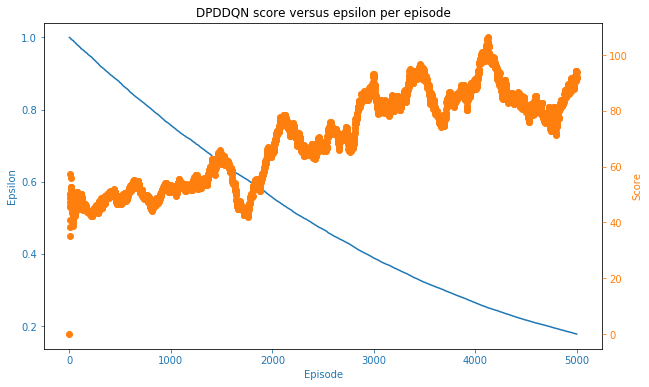

In [73]:
# plot score scatter chart overlaid with epsilon to see relationships

fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.plot(range(len(episode_eps_dpddqn)), episode_eps_dpddqn, color="C0")
ax.set_xlabel("Episode", color="C0")
ax.set_ylabel("Epsilon", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")

N = len(episode_scores_dpddqn)
running_avg = np.empty(N)
for t in range(N):
    running_avg[t] = np.mean(episode_scores_dpddqn[max(0, t-200):(t+1)])

ax2.scatter(range(len(running_avg)), running_avg, color="C1")
ax2.axes.get_xaxis().set_visible(False)
ax2.yaxis.tick_right()
ax2.set_ylabel('Score', color="C1")
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='y', colors="C1")

plt.title(f'DPDDQN score versus epsilon per episode')
plt.savefig(plots_path + output_dir + f'{agent}_score_vs_eps_plot.png')
plt.show()

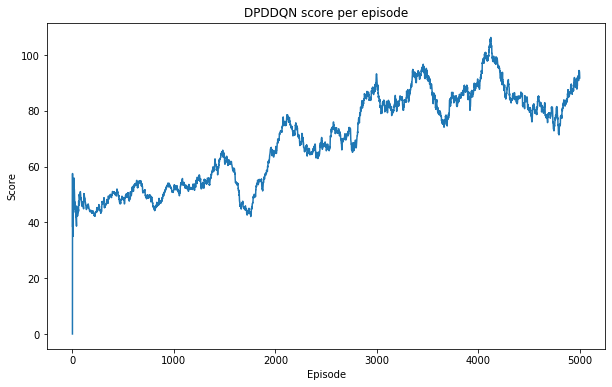

In [76]:
# plot score over episodes

plt.figure(figsize=(10,6))

# get moving average
N = len(episode_scores_dpddqn)
running_avg = np.empty(N)
for t in range(N):
    running_avg[t] = np.mean(episode_scores_dpddqn[max(0, t-200):(t+1)])

# do plot
plt.plot(range(len(running_avg)), running_avg)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title(f'DPDDQN score per episode')
plt.savefig(plots_path + output_dir + f'{agent}_score_plot.png')
plt.show()

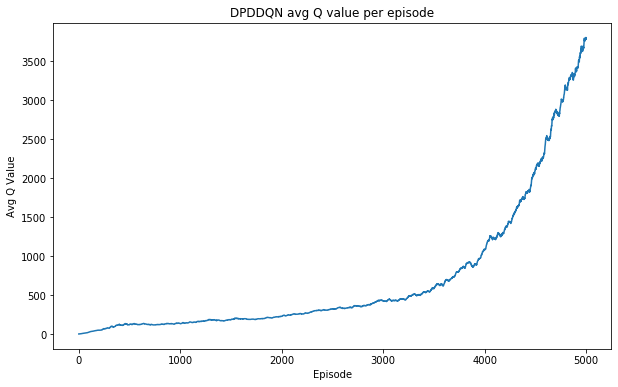

In [46]:
# plot q values over episodes

plt.figure(figsize=(10,6))

# get moving average
N = len(episode_scores_dpddqn)
running_avg = np.empty(N)
for t in range(N):
    running_avg[t] = np.mean(episode_qs_dpddqn[max(0, t-20):(t+1)])

# do plot
plt.plot(range(len(running_avg)), running_avg)
plt.xlabel('Episode')
plt.ylabel('Avg Q Value')
plt.title(f'DPDDQN avg Q value per episode')
plt.savefig(plots_path + output_dir + f'{agent}_qvalue_plot.png')
plt.show()

## Agent training comparison

### DQN vs DDQN

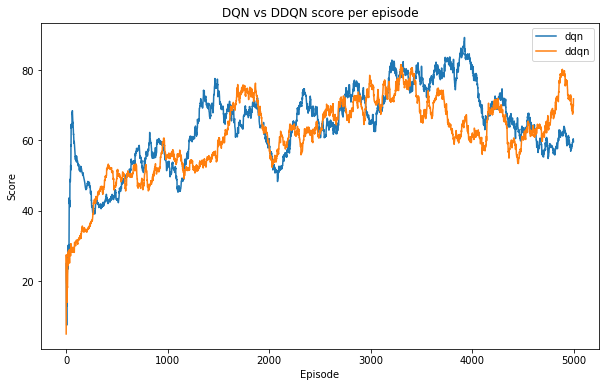

In [74]:
# score per episode

plt.figure(figsize=(10,6))

# get moving average
N_dqn = len(episode_scores_dqn)
N_ddqn = len(episode_scores_ddqn)
running_avg_dqn = np.empty(N_dqn)
running_avg_ddqn = np.empty(N_ddqn)
for t in range(N_dqn):
    running_avg_dqn[t] = np.mean(episode_scores_dqn[max(0, t-200):(t+1)])
for t in range(N_ddqn):
    running_avg_ddqn[t] = np.mean(episode_scores_ddqn[max(0, t-200):(t+1)])

# do plot
plt.plot(range(len(running_avg_dqn)), running_avg_dqn, label='dqn')
plt.plot(range(len(running_avg_ddqn)), running_avg_ddqn, label='ddqn')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title(f'DQN vs DDQN score per episode')
plt.legend()
plt.savefig(plots_path + output_dir + 'dqn_vs_ddqn_score_plot.png')
plt.show()

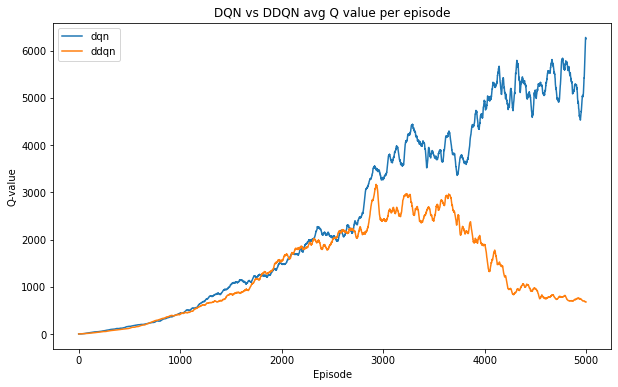

In [77]:
# q value per episode

plt.figure(figsize=(10,6))
# get moving average
N_dqn = len(episode_qs_dqn)
N_ddqn = len(episode_qs_ddqn)
running_avg_dqn = np.empty(N_dqn)
running_avg_ddqn = np.empty(N_ddqn)
for t in range(N_dqn):
    running_avg_dqn[t] = np.mean(episode_qs_dqn[max(0, t-20):(t+1)])
for t in range(N_ddqn):
    running_avg_ddqn[t] = np.mean(episode_qs_ddqn[max(0, t-20):(t+1)])

# do plot
plt.plot(range(len(running_avg_dqn)), running_avg_dqn, label='dqn')
plt.plot(range(len(running_avg_ddqn)), running_avg_ddqn, label='ddqn')
plt.xlabel('Episode')
plt.ylabel('Q-value')
plt.title(f'DQN vs DDQN avg Q value per episode')
plt.legend()
plt.savefig(plots_path + output_dir + 'dqn_vs_ddqn_qvalue_plot.png')
plt.show()

### All agents

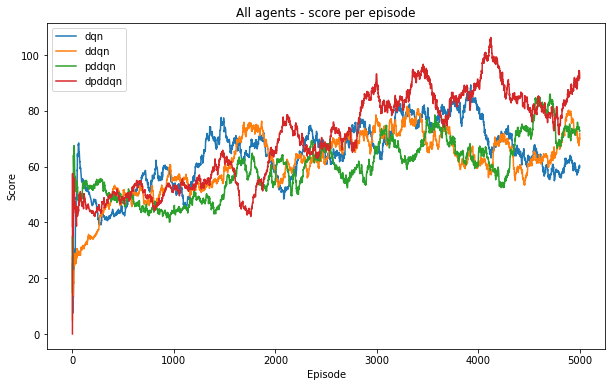

In [69]:
# score per episode
plt.figure(figsize=(10,6))

# get moving average
N_dqn = len(episode_scores_dqn)
N_ddqn = len(episode_scores_ddqn)
N_pddqn = len(episode_scores_pddqn)
N_dpddqn = len(episode_scores_dpddqn)
running_avg_dqn = np.empty(N_dqn)
running_avg_ddqn = np.empty(N_ddqn)
running_avg_pddqn = np.empty(N_pddqn)
running_avg_dpddqn = np.empty(N_dpddqn)
for t in range(N_dqn):
    running_avg_dqn[t] = np.mean(episode_scores_dqn[max(0, t-200):(t+1)])
for t in range(N_ddqn):
    running_avg_ddqn[t] = np.mean(episode_scores_ddqn[max(0, t-200):(t+1)])
for t in range(N_pddqn):
    running_avg_pddqn[t] = np.mean(episode_scores_pddqn[max(0, t-200):(t+1)])
for t in range(N_dpddqn):
    running_avg_dpddqn[t] = np.mean(episode_scores_dpddqn[max(0, t-200):(t+1)])

# do plot
plt.plot(range(len(running_avg_dqn)), running_avg_dqn, label='dqn')
plt.plot(range(len(running_avg_ddqn)), running_avg_ddqn, label='ddqn')
plt.plot(range(len(running_avg_pddqn)), running_avg_pddqn, label='pddqn')
plt.plot(range(len(running_avg_dpddqn)), running_avg_dpddqn, label='dpddqn')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title(f'All agents - score per episode')
plt.legend()
plt.savefig(plots_path + output_dir + 'all_agents_score_plot.png')
plt.show()

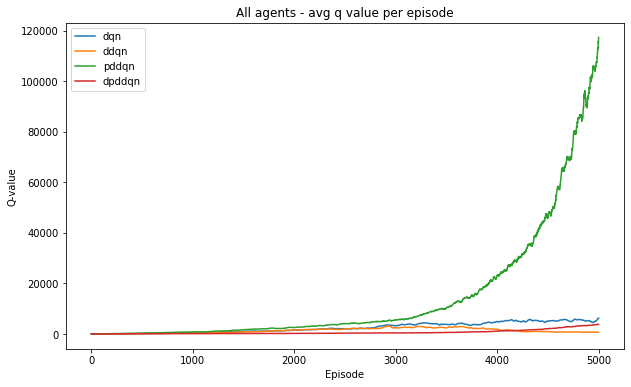

In [78]:
# q value per episode
plt.figure(figsize=(10,6))

# get moving average
N_dqn = len(episode_qs_dqn)
N_ddqn = len(episode_qs_ddqn)
N_pddqn = len(episode_qs_pddqn)
N_dpddqn = len(episode_qs_dpddqn)
running_avg_dqn = np.empty(N_dqn)
running_avg_ddqn = np.empty(N_ddqn)
running_avg_pddqn = np.empty(N_pddqn)
running_avg_dpddqn = np.empty(N_dpddqn)
for t in range(N_dqn):
    running_avg_dqn[t] = np.mean(episode_qs_dqn[max(0, t-20):(t+1)])
for t in range(N_ddqn):
    running_avg_ddqn[t] = np.mean(episode_qs_ddqn[max(0, t-20):(t+1)])
for t in range(N_pddqn):
    running_avg_pddqn[t] = np.mean(episode_qs_pddqn[max(0, t-20):(t+1)])
for t in range(N_dpddqn):
    running_avg_dpddqn[t] = np.mean(episode_qs_dpddqn[max(0, t-20):(t+1)])

# do plot
plt.plot(range(len(running_avg_dqn)), running_avg_dqn, label='dqn')
plt.plot(range(len(running_avg_ddqn)), running_avg_ddqn, label='ddqn')
plt.plot(range(len(running_avg_pddqn)), running_avg_pddqn, label='pddqn')
plt.plot(range(len(running_avg_dpddqn)), running_avg_dpddqn, label='dpddqn')
plt.xlabel('Episode')
plt.ylabel('Q-value')
plt.title(f'All agents - avg q value per episode')
plt.legend()
plt.savefig(plots_path + output_dir + 'all_agents_qvalue_plot.png')
plt.show()

## Test agents

### Random Agent (Baseline)

Agent that takes a random action at each step

In [63]:
# create lists for storing stats
episode_scores_fa_test = []

# number of episodes to play
n_episodes = 20
print('Number of episodes:', n_episodes)

for episode in range(n_episodes):
    observation = env.reset()
    #create episode reward counter
    total_reward = 0.0
    for t in count():
        #select action randomly
        action = env.action_space.sample()
        
        #perform action 
        observation, reward, done, info = env.step(action)
        
        #increase reward
        total_reward += reward
        
        if done:
            break
                       
    # track total score for each episode
    episode_scores_fa_test.append(total_reward)
              
print('Complete')


Number of episodes: 20
Complete


In [64]:
# get average score and std
avg_score = np.mean(episode_scores_fa_test)
std_score = np.std(episode_scores_fa_test)
print('Avg Score: {:.2f}, Std: {:.2f}'.format(avg_score, std_score))

Avg Score: 37.50, Std: 33.34


### DQN

In [53]:
# create lists for storing stats
episode_scores_dqn_test = []

# number of episodes to play
n_episodes = 20
print('Number of episodes:', n_episodes)

for episode in range(n_episodes):
    observation = env.reset()
    # get initial state
    state = get_state(observation)
    #create episode reward counter
    total_reward = 0.0
    for t in count():
        #select action
        action = policy_net_dqn(state.to(device)).max(1)[1].view(1, 1)
 
        #perform action 
        if N_ACTIONS == 5:
            observation, reward, done, info = env.step(action.item() + 1)
        elif N_ACTIONS == 6:
            observation, reward, done, info = env.step(action.item())

        #increase reward
        total_reward += reward

        #get next state
        if not done:
            next_state = get_state(observation)
        else:
            next_state = None
        
        if done:
            break
                       
    # track total score for each episode
    episode_scores_dqn_test.append(total_reward)
              
print('Complete')


Number of episodes: 20
Complete


In [54]:
# get average score and std
avg_score = np.mean(episode_scores_dqn_test)
std_score = np.std(episode_scores_dqn_test)
print('Avg Score: {:.2f}, Std: {:.2f}'.format(avg_score, std_score))

Avg Score: 72.75, Std: 40.88


### Double DQN

In [55]:
# create lists for storing stats
episode_scores_ddqn_test = []

# number of episodes to play
n_episodes = 20
print('Number of episodes:', n_episodes)

for episode in range(n_episodes):
    observation = env.reset()
    # get initial state
    state = get_state(observation)
    #create episode reward counter
    total_reward = 0.0
    for t in count():
        #select action
        action = policy_net_ddqn(state.to(device)).max(1)[1].view(1, 1)
        
        #perform action 
        if N_ACTIONS == 5:
            observation, reward, done, info = env.step(action.item() + 1)
        elif N_ACTIONS == 6:
            observation, reward, done, info = env.step(action.item())
        
        #increase reward
        total_reward += reward

        #get next state
        if not done:
            next_state = get_state(observation)
        else:
            next_state = None
        
        if done:
            break
                       
    # track total score for each episode
    episode_scores_ddqn_test.append(total_reward)
              
print('Complete')


Number of episodes: 20
Complete


In [56]:
# get average score and std
avg_score = np.mean(episode_scores_ddqn_test)
std_score = np.std(episode_scores_ddqn_test)
print('Avg Score: {:.2f}, Std: {:.2f}'.format(avg_score, std_score))

Avg Score: 91.50, Std: 51.07


### Prioritised Double DQN

In [87]:
# create lists for storing stats
episode_scores_pddqn_test = []

# number of episodes to play
n_episodes = 20
print('Number of episodes:', n_episodes)

for episode in range(n_episodes):
    observation = env.reset()
    # get initial state
    state = get_state(observation)
    #create episode reward counter
    total_reward = 0.0
    for t in count():
        #select action
        action = policy_net_pddqn(state.to(device)).max(1)[1].view(1, 1)
        
        #perform action 
        if N_ACTIONS == 5:
            observation, reward, done, info = env.step(action.item() + 1)
        elif N_ACTIONS == 6:
            observation, reward, done, info = env.step(action.item())
        
        #increase reward
        total_reward += reward

        #get next state
        if not done:
            next_state = get_state(observation)
        else:
            next_state = None
        
        if done:
            break
                       
    # track total score for each episode
    episode_scores_pddqn_test.append(total_reward)
              
print('Complete')


Number of episodes: 20
Complete


In [88]:
# get average score and std
avg_score = np.mean(episode_scores_pddqn_test)
std_score = np.std(episode_scores_pddqn_test)
print('Avg Score: {:.2f}, Std: {:.2f}'.format(avg_score, std_score))

Avg Score: 33.00, Std: 45.81


### Dueling Prioritised Double DQN

In [59]:
# create lists for storing stats
episode_scores_dpddqn_test = []

# number of episodes to play
n_episodes = 20
print('Number of episodes:', n_episodes)

for episode in range(n_episodes):
    observation = env.reset()
    # get initial state
    state = get_state(observation)
    #create episode reward counter
    total_reward = 0.0
    for t in count():
        #select action
        action = policy_net_dpddqn(state.to(device)).max(1)[1].view(1, 1)
        
        #perform action 
        if N_ACTIONS == 5:
            observation, reward, done, info = env.step(action.item() + 1)
        elif N_ACTIONS == 6:
            observation, reward, done, info = env.step(action.item())
        
        #increase reward
        total_reward += reward

        #get next state
        if not done:
            next_state = get_state(observation)
        else:
            next_state = None
        
        if done:
            break
                       
    # track total score for each episode
    episode_scores_dpddqn_test.append(total_reward)
              
print('Complete')


Number of episodes: 20
Complete


In [60]:
# get average score and std
avg_score = np.mean(episode_scores_dpddqn_test)
std_score = np.std(episode_scores_dpddqn_test)
print('Avg Score: {:.2f}, Std: {:.2f}'.format(avg_score, std_score))

Avg Score: 60.00, Std: 59.69


### Comparison

#### DQN, DDQN, Baseline

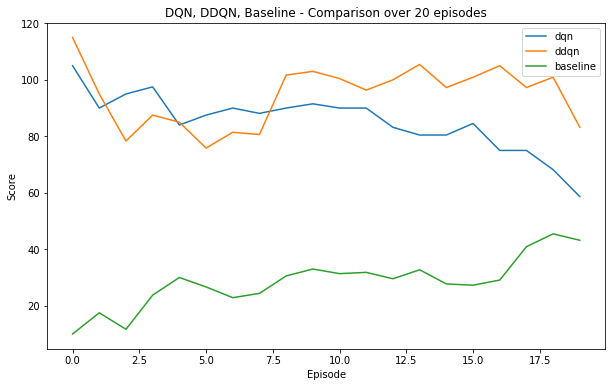

In [65]:
plt.figure(figsize=(10,6))
# get moving average
N = len(episode_scores_dqn_test)
running_avg_dqn = np.empty(N)
running_avg_ddqn = np.empty(N)
running_avg_fa = np.empty(N)
for t in range(N):
    running_avg_dqn[t] = np.mean(episode_scores_dqn_test[max(0, t-10):(t+1)])
    running_avg_ddqn[t] = np.mean(episode_scores_ddqn_test[max(0, t-10):(t+1)])
    running_avg_fa[t] = np.mean(episode_scores_fa_test[max(0, t-10):(t+1)])

# do plot
plt.plot(range(len(running_avg_dqn)), running_avg_dqn, label='dqn')
plt.plot(range(len(running_avg_ddqn)), running_avg_ddqn, label='ddqn')
plt.plot(range(len(running_avg_fa)), running_avg_fa, label='baseline')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.legend()
plt.title(f'DQN, DDQN, Baseline - Comparison over 20 episodes')
plt.savefig(plots_path + output_dir + 'DQN_vs_DDQN_agents_test_score_plot.png')
plt.show()

#### All agents

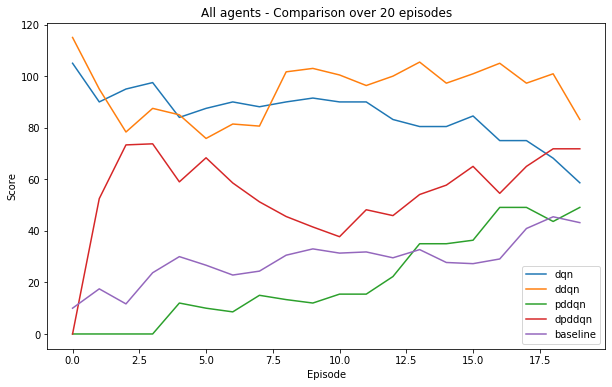

In [89]:
plt.figure(figsize=(10,6))
# get moving average
N = len(episode_scores_dqn_test)
running_avg_dqn = np.empty(N)
running_avg_ddqn = np.empty(N)
running_avg_pddqn = np.empty(N)
running_avg_dpddqn = np.empty(N)
running_avg_fa = np.empty(N)
for t in range(N):
    running_avg_dqn[t] = np.mean(episode_scores_dqn_test[max(0, t-10):(t+1)])
    running_avg_ddqn[t] = np.mean(episode_scores_ddqn_test[max(0, t-10):(t+1)])
    running_avg_pddqn[t] = np.mean(episode_scores_pddqn_test[max(0, t-10):(t+1)])
    running_avg_dpddqn[t] = np.mean(episode_scores_dpddqn_test[max(0, t-10):(t+1)])
    running_avg_fa[t] = np.mean(episode_scores_fa_test[max(0, t-10):(t+1)])

# do plot
plt.plot(range(len(running_avg_dqn)), running_avg_dqn, label='dqn')
plt.plot(range(len(running_avg_ddqn)), running_avg_ddqn, label='ddqn')
plt.plot(range(len(running_avg_pddqn)), running_avg_pddqn, label='pddqn')
plt.plot(range(len(running_avg_dpddqn)), running_avg_dpddqn, label='dpddqn')
plt.plot(range(len(running_avg_fa)), running_avg_fa, label='baseline')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.legend()
plt.title(f'All agents - Comparison over 20 episodes')
plt.savefig(plots_path + output_dir + 'all_agents_test_score_plot.png')
plt.show()